# Comparison of algortihms/ansatz in Li-H ground state search
## VQE
## AdaptVQE
## VHA
## Imaginary time evolution

##

In [21]:
#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.19.0','qiskit-aer': '0.8.2','qiskit-nature': '0.2.0'
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.18.2', 'qiskit-aer': '0.9.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.5', 'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [22]:
import os
os.environ["TMPDIR"] = "/tmp"  # set the folder for temporary files
import sys 
sys.path.insert(0, '/home/gsilvi/.local/lib/python3.9/site-packages')

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE
from qiskit_nature.circuit.library import HartreeFock, UCCSD,UCC

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B,SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit.library import TwoLocal
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator,QasmSimulator

# import HQStyle
# HQStyle.import_all()
from qiskit_mod.qiskit_nat import VHA
from qiskit_mod.qiskit_ter import LinCombFullmod,LinCombMod

import numpy as np 
import time as time
import matplotlib.pyplot as plt



In [30]:
use_qlm = True # instead of Qiskit

use_remote_qlm = True # use QLM remote server

usenoise = True  # Noise available for Qiskit or QLM remote

In [31]:
#'qiskit-terra': '0.18.2', 'qiskit-aer': '0.8.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-aqua': None, 
#'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None

# from qat.qlmaas import QLMaaSConnection

# conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu")
# conn.create_config()

In [33]:
# simulators choice
shots=1024
seed = 24

###### NOISE MODEL FOR QLM 
from qat.hardware.default import DefaultGatesSpecification, HardwareModel
from qat.hardware import make_depolarizing_hardware_model
from qat.quops import make_depolarizing_channel

gates_spec = DefaultGatesSpecification()
# instantiating a noise model representing a depolarizing noise
# with probability 5%
noise = make_depolarizing_channel(prob=0.05, nqbits=1)

# for each gate, we specify the noise
# note that the values in this dictionary are lambda functions
# with as many arguments as the gate's number of arguments
gates_noise = {"H": lambda: noise, "RX": lambda _: noise}

#TWO MODEL TO CHOOSE FROM
hw_model_1 = HardwareModel(gates_spec, gates_noise, idle_noise=None)

#hw_model_2 = make_depolarizing_hardware_model(eps1=0.01, eps2=0.1) # depolarizing noise with average error rate ϵ1 (one-qubit errors) and ϵ2 (two-qubit errors)

hw_model_to_use =hw_model_1



###### SIMULATOR CHOICE
if use_qlm or use_remote_qlm:
    quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator')) # just a place holder

    #OVERRIDE  VQE`s get_energy_evalutation with qlm-modified version
    from qiskit_mod.wrapper2myqlm import *
    from qiskit_mod.my_junction import IterativeExplorationVQE,get_energy_evaluation_QLM
    VQE.get_energy_evaluation = get_energy_evaluation_QLM #override the function, class-wide
    plugin_in_use = IterativeExplorationVQE

    
    if use_remote_qlm:

        print('Using QLM remote Backend', end=' ')
        
        
        from qlmaas.plugins import IterativeExplorationVQE as IterativeExplorationVQEremote
        if usenoise:
            print('with Noise')
            from qlmaas.qpus import NoisyQProc


            qpu_remote = NoisyQProc(hardware_model = hw_model_to_use, sim_method = "deterministic")
        else:
            print('without Noise')
            from qlmaas.qpus import LinAlg
            qpu_remote = LinAlg() #remote
        qlm_qpu = qpu_remote
        plugin_in_use = IterativeExplorationVQEremote
    else:
        print('Using QLM local Backend')

        if usenoise and False:  #NOT AVAILABLE IN QLM LOCAL
            print('with Noise')
            #from qat.qpus import NoisyQProc 

            qpu_local = NoisyQProc(hardware_model = hw_model_to_use, sim_method = "deterministic")
        else:
            print('without Noise')
            from qat.qpus import PyLinalg
            qpu_local = PyLinalg() #local
        qlm_qpu = qpu_local
        
else:
    print('Using Qiskit local Backend', end=' ')
    backend = Aer.get_backend('aer_simulator')
    #backend_sv = Aer.get_backend('statevector_simulator')
    if usenoise:
        # NOISE
        print('with Noise')
        device_backend = FakeVigo() #noise model for qiskit
        device = QasmSimulator.from_backend(device_backend) 
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        quantum_instance = QuantumInstance(backend=backend, 
                                           seed_simulator=seed,
                                           seed_transpiler=seed,
                                           coupling_map=coupling_map,
                                           noise_model=noise_model,
                                           shots=shots,
                                           max_credits=None) # max_credits=None necessary with myqlm
    else:
        print('without Noise')
        usenoise = False
        quantum_instance = QuantumInstance(backend=backend,
                                           shots=shots,
                                           max_credits=None)
    



Using QLM local Backend
without Noise


Simulation parameters 

In [ ]:
# SIMULATION PARAMETERS

# Molecule
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
orbitals_to_remove = [4,5]
basis = 'sto3g'

# Distance to be used for the VQE
distances = np.arange(1, 4.5, 1)  # angstrom distance
print('Range of distance to compute:',distances)


# Optimizer
optimizer = L_BFGS_B(maxiter=1000)
#optimizer = COBYLA(maxiter=1000)
#optimizer = SPSA(maxiter=100)


# VHA parameters
trotter_steps = 3
time_step_size = 1
# prepare intial point for VHA, inspired by adiabatic evolution
ip = []
for i in range(trotter_steps):
    ip.append(time_step_size*((i+1)/trotter_steps))  # param for H_ex = V
    ip.append(time_step_size)                        # param for H_hop = H_0
    ip.append(time_step_size)                        # param for H_diag = H_0

print('Initial parameter for VHA, '+str(trotter_steps)+'*(H_ex,H_op,H_diag)=', ip)

Range of distance to compute: [1. 2. 3. 4.]
Initial parameter for VHA, 3*(H_ex,H_op,H_diag)= [0.3333333333333333, 1, 1, 0.6666666666666666, 1, 1, 1.0, 1, 1]


In [ ]:
#%%pycodestyle

exact_energies, hf_energies, vqe_energies, adapt_vqe_energies, Ievo_energies, Ievo_params, vqe_params, adapt_vqe_params, vha_energies, vha_params = ([] for i in range(10))



# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()
# Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)  # two qubit reduction doesn`t work with Jordan-WignerMapper()

for i, bond_distance in enumerate(distances):  # loop over distances
    print('\n Step', i, ', bond_distance =', bond_distance)
    molecule_set = molecule.format(bond_distance/2)
    driver = PySCFDriver(atom=molecule_set,
                         unit=UnitsType.ANGSTROM,
                         basis=basis)
    #qmolecule = driver.run()
    es_problem = ElectronicStructureProblem(driver,
                                            q_molecule_transformers = [FreezeCoreTransformer(freeze_core = True,
                                                                                           remove_orbitals = orbitals_to_remove
                                                                                           )]
                                            )
    second_q_op = es_problem.second_q_ops()
    qubit_op = qubit_converter.convert(second_q_op[0],
                                       num_particles = es_problem.num_particles) #this line is useful for initialize the converter and get the right hartree-fock number of qubits
    particle_number = es_problem.properties_transformed.get_property("ParticleNumber")

    # Initialize solvers
    

    # Imag. Evo/ Natural gradient solver
    hartree_fock_state = HartreeFock(particle_number.num_spin_orbitals,
                                     (particle_number.num_alpha, particle_number.num_beta),
                                     qubit_converter)
    print('Number of qubits:',hartree_fock_state.num_qubits)

    nat_grad = NaturalGradient(grad_method=LinCombMod(img=False),
                               qfi_method=LinCombFullmod(),
                               regularization='ridge')
    ansz = TwoLocal(hartree_fock_state.num_qubits,
                    rotation_blocks=['ry'], 
                    entanglement_blocks='cx',
                    entanglement="full",
                    reps=1,
                    initial_state=hartree_fock_state)
    Im_solver = VQEUCCFactory(quantum_instance,
                              gradient=nat_grad,
                              optimizer=COBYLA(maxiter=1000), # good optimizer for Nat. Grad.
                              ansatz=ansz.decompose())
    calcIevo = GroundStateEigensolver(qubit_converter,
                                      Im_solver)

    # vqe solver
    vqe_solver = VQEUCCFactory(quantum_instance,
                               optimizer=optimizer)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)

    # vha solver
    vha_solver = VQEUCCFactory(quantum_instance,
                               optimizer = optimizer,
                               initial_point = np.asarray(ip),
                               ansatz = VHA(excitations = 'sd',
                                            trotter_steps = trotter_steps,
                                            only_excitations = True))
    calcVHA = GroundStateEigensolver(qubit_converter, vha_solver)



    # adapt vqe solver
    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=0.001)

    # exact numpy solver
    exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)

    # Run the computation

    ## Compute exact ground state
    start = time.time()
    res3 = exact_calc.solve(es_problem)
    exact_energies.append(res3.total_energies)
    end = time.time()
    print('Exact:\t', res3.total_energies, ',exec_time=', end - start, 's')
 
    ## Compute ground state with Imaginary time evo  
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calcIevo,molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots = shots,
                                remove_orbitals = orbitals_to_remove)
        resIevo = run_QLM_stack(stack)
    else:
        resIevo = calcIevo.solve(es_problem)
    Ievo_energies.append(np.real(resIevo.total_energies))
    Ievo_params.append(len(resIevo.raw_result.optimal_parameters))
    end = time.time()
    print('Imaginary time evo. ,',
          resIevo.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resIevo.raw_result.optimal_parameters))
    
    ## Compute ground state with VQE
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calc,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        res = run_QLM_stack(stack)
    else:
        res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies))
    hf_energies.append(res.hartree_fock_energy)
    vqe_params.append(len(res.raw_result.optimal_parameters))
    end = time.time()
    print('VQE:\t', res.total_energies,
        ',exec_time=', end - start,
        's, number of optimal parameters=', len(res.raw_result.optimal_parameters))

    ## Compute ground state with AdaptVQE
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(adapt_calc,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        res2 = run_QLM_stack(stack)
    else:
        res2 = adapt_calc.solve(es_problem)
    adapt_vqe_energies.append(np.real(res2.total_energies))
    adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
    end = time.time()
    print('AdaptVQE:', res2.total_energies,
          ',exec_time=', end - start,
          's,number of optimal parameters=', len(res2.raw_result.optimal_parameters))

    ## Compute ground state with VHA
    start = time.time()
    if use_qlm or use_remote_qlm:
        stack = build_QLM_stack(calcVHA,
                                molecule_set,
                                plugin_in_use,
                                qlm_qpu,
                                shots=shots,
                                remove_orbitals=orbitals_to_remove)
        resVHA = run_QLM_stack(stack)
    else:
        resVHA = calcVHA.solve(es_problem)
    vha_energies.append(np.real(resVHA.total_energies))
    vha_params.append(len(resVHA.raw_result.optimal_parameters))
    end = time.time()
    print('VHA ,', trotter_steps, 'steps:',
          resVHA.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resVHA.raw_result.optimal_parameters))
          


 Step 0 , bond_distance = 1.0
Number of qubits: 8
Exact:	 [-7.78402132+0.j] ,exec_time= 3.9909644139988814 s
Submitted a new batch: Job4818
Waiting for remote job to complete....	done
Imaginary time evo. , -7.668378706726913 ,exec_time= 92.86058766900169 s, number of optimal parameters= 16
Submitted a new batch: Job4819
Waiting for remote job to complete....	done
VQE:	 -7.784021320446178 ,exec_time= 69.51682917600192 s, number of optimal parameters= 24
Submitted a new batch: Job4820
Waiting for remote job to complete....	done
AdaptVQE: -7.783752813787232 ,exec_time= 272.39357739299885 s,number of optimal parameters= 7
Submitted a new batch: Job4821
Waiting for remote job to complete....	done
VHA , 3 steps: -7.586863307886563 ,exec_time= 162.45296917499945 s, number of optimal parameters= 9

 Step 1 , bond_distance = 2.0
Number of qubits: 8
Exact:	 [-7.86082826+0.j] ,exec_time= 4.643312349999178 s
Submitted a new batch: Job4822
Waiting for remote job to complete....	done
Imaginary time

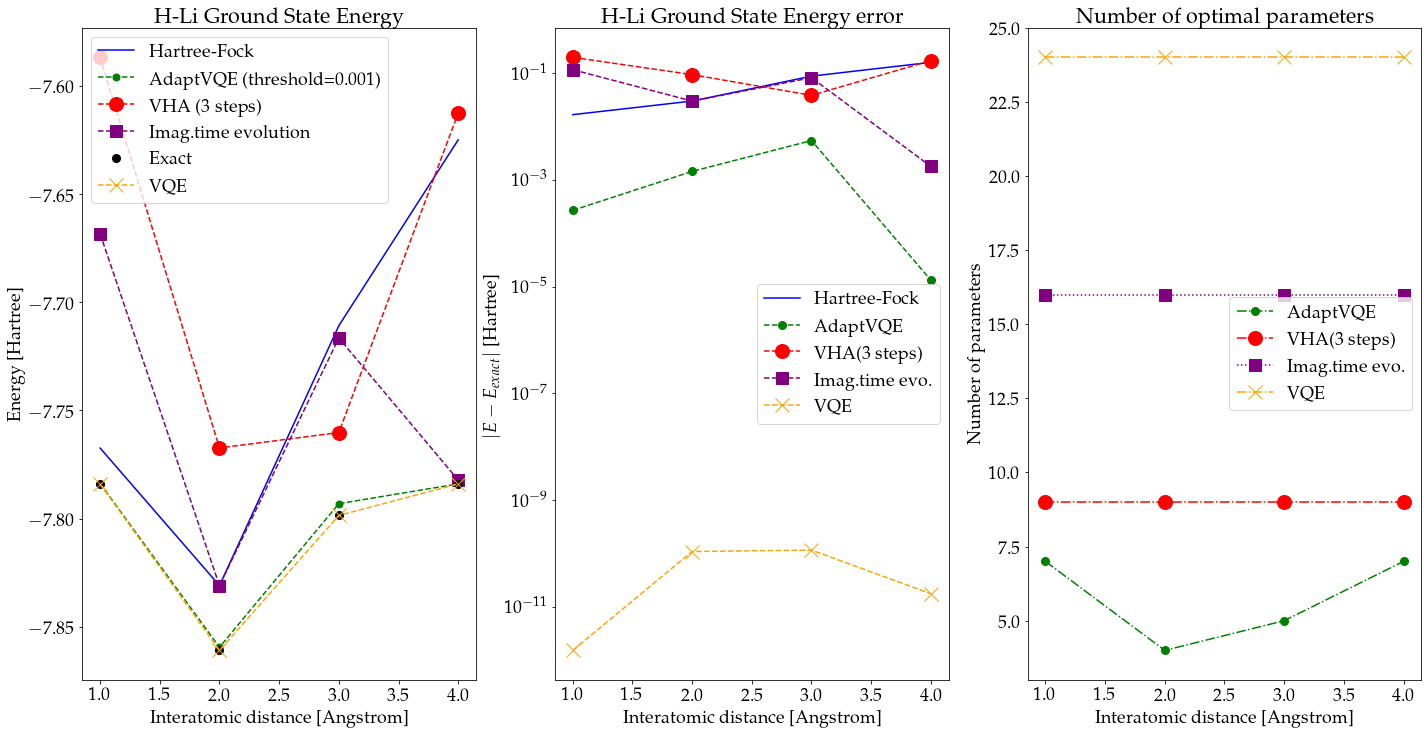

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Palatino"],
    'font.size'   : 18})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

ax1.plot(distances, hf_energies, color='blue', label='Hartree-Fock')
ax1.plot(distances, adapt_vqe_energies, '.',markersize=14,linestyle='--', color='green', label='AdaptVQE (threshold=0.001)')
ax1.plot(distances, vha_energies, 'o',markersize=14,linestyle='--', color='red', label='VHA ('+str(trotter_steps)+' steps)')
ax1.plot(distances, Ievo_energies, 's',markersize=12,linestyle='--', color='purple', label='Imag.time evolution')
ax1.plot(distances, exact_energies, '.',markersize=16, color='black', label='Exact')
ax1.plot(distances, vqe_energies, 'x',markersize=14,linestyle='--', color='orange', label='VQE')
ax1.set_xlabel('Interatomic distance [Angstrom]')
ax1.set_ylabel('Energy [Hartree]')
ax1.set_title('H-Li Ground State Energy')
ax1.legend(loc='upper left')


ypoints = [abs(a - b) for a, b in zip(hf_energies, exact_energies)]
ax2.plot(distances, ypoints, color='blue', label='Hartree-Fock')
ypoints = [abs(a - b) for a, b in zip(adapt_vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, '.',markersize=16, linestyle='--', color='green', label='AdaptVQE')
ypoints = [abs(a - b) for a, b in zip(vha_energies, exact_energies)]
ax2.plot(distances, ypoints, 'o',markersize=14, linestyle='--', color='red', label='VHA('+str(trotter_steps)+' steps)')
ypoints = [abs(a - b) for a, b in zip(Ievo_energies, exact_energies)]
ax2.plot(distances, ypoints, 's',markersize=12, linestyle='--', color='purple', label='Imag.time evo.')
ypoints = [abs(a - b) for a, b in zip(vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, 'x',markersize=14, linestyle='--', color='orange', label='VQE')

ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance [Angstrom]')
ax2.set_ylabel('$|E-E_{exact}|$ [Hartree]')
ax2.set_title('H-Li Ground State Energy error')
ax2.legend()



ax3.plot(distances, adapt_vqe_params, '.',markersize=16, linestyle='-.', color='green', label='AdaptVQE')
ax3.plot(distances, vha_params, 'o',markersize=14, linestyle='-.', color='red', label='VHA('+str(trotter_steps)+' steps)')
ax3.plot(distances, Ievo_params, 's',markersize=12, linestyle=':', color='purple', label='Imag.time evo.')
ax3.plot(distances, vqe_params, 'x',markersize=14, linestyle='-.', color='orange', label='VQE')

ax3.set_xlabel('Interatomic distance [Angstrom]')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend()


if usenoise==True: fig.savefig('LiH_ground_energy_noise.pdf')
else: fig.savefig('LiH_ground_energy.pdf')